# Useful utilities

This notebook shows some useful tools developed within this project.
They are not the main goal of this project but may turn to be useful
for various applications

---

In [2]:
import os

cur_dir = os.getcwd()
if os.path.basename(cur_dir) == "notebooks":
    os.chdir(os.path.dirname(cur_dir))

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src.utils.lattice_utils.lattice import Lattice
from src.utils.lattice_utils.split_lines import infer_split_lines
from src.utils.lattice_utils.data_manipulations import crop_facade
from src.visualize.img_mask import draw_facade_and_mask, draw_facade_with_split_lines
from src.utils.grammars_utils.training_utils import load_facade_and_mask
from src.utils.grammars_utils.general_grammar import parse_facade, get_tree_loss
from src.utils.grammars_utils.earley_parsing import EarleyParser2D

### Helper functions

**Loading facade and its segmentation mask**

Suppose we store facades' images and their segmentation masks
in directories structure as below:

```
input_all
├── a
│   ├── nadodrze_cybulskiego_22.png
│   ├── nadodrze_cybulskiego_24.png
│   ├── ...
└── b
    ├── nadodrze_cybulskiego_22.png
    ├── nadodrze_cybulskiego_24.png
    ├── ...
```

where the `a` directory contains facades' masks and the `b` directory contains their images.

We can conveniently load both the image and the mask of a facade:

In [4]:
some_facade_img, some_facade_mask = load_facade_and_mask(
    "nadodrze_cybulskiego_24",
    imgs_dir="input_all/b",
    masks_dir="input_all/a"
)

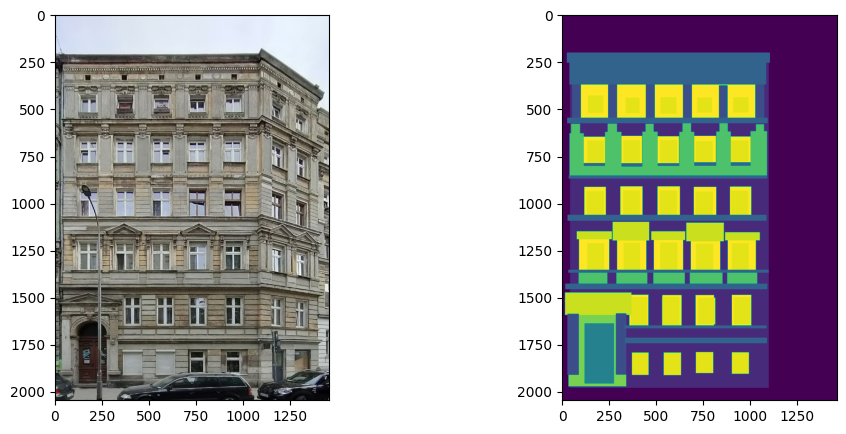

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].imshow(some_facade_img[:,:,::-1])
axes[1].imshow(some_facade_mask[:,:,0])
plt.show()

**Drawing facade and its segmentation mask**

There is a helper function for convenient plotting:

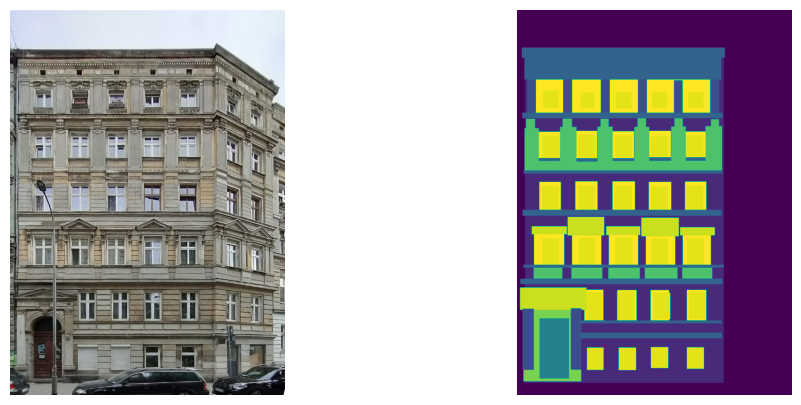

In [11]:
draw_facade_and_mask(
    img=some_facade_img,
    mask=some_facade_mask[:,:,0],
    show_axis=False
)